In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import random
import math
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
from sklearn.metrics import hamming_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC



from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC


# 1. Multi-class and Multi-Label Classification Using Support Vector Machines

In [2]:
mfcc_path = "../data/Frogs_MFCCs.csv"

mfcc_data = pd.read_csv(mfcc_path)

In [3]:
mfcc_data['Family'], family_labels = pd.factorize(mfcc_data['Family'])
mfcc_data['Genus'], genus_labels = pd.factorize(mfcc_data['Genus'])
mfcc_data['Species'], species_labels = pd.factorize(mfcc_data['Species'])


In [4]:
#split 70% for training

train = random.sample(range(mfcc_data.shape[0]), math.ceil(mfcc_data.shape[0]*0.7))
train.sort()
test = [i for i in range(mfcc_data.shape[0]) if i not in train ]

In [5]:
len(mfcc_data), len(train)

(7195, 5037)

In [6]:
train_data = mfcc_data.iloc[train,:].reset_index(drop = True)
test_data = mfcc_data.iloc[test,:].reset_index(drop=True)


In [54]:
# split train features and labels
train_X = train_data.iloc[:, :-4]
train_Family = train_data.iloc[:, -4]
train_Genus = train_data.iloc[:, -3]
train_Species = train_data.iloc[:, -2]

# split test features and labels
test_X = test_data.iloc[:, :-4]
test_Family = test_data.iloc[:, -4]
test_Genus = test_data.iloc[:, -3]
test_Species = test_data.iloc[:, -2]

In [8]:
train_data.shape


(5037, 26)

## 1.(b) Solve a multi-class and multi-label problem¶

1.(b)-i Exact match and hamming score/ loss methods for evaluating multi-label classification¶

Hamming Loss: the fraction of the wrong labels to the total number of labels

Exact Match Ratio: percentage of datapoints that have all their labels classified 100% correctly


## 1.(b)-ii Train a SVM for each of the labels, using Gaussian kernels and one versus all classifiers

In [9]:
# define a param search function that will be easy to apply

def paramSearch(classifier, param, trainX, trainY, testX, testY):
    model = GridSearchCV(estimator=classifier, **param,error_score=np.NINF)
    model.fit(trainX, trainY)    
    
    print("\nThe best parameters are:")
    print(model.best_params_, "\n")
    
    test_pred = model.predict(testX)

    print(classification_report(testY, test_pred))
    return model

** Gaussian SVC without standardization **

In [10]:
#create a set to store model results 
gaussian_SVC = {}

#creat a list of parameters 
tune_params = {'C' : np.logspace(1, 3,3 ),'gamma' : np.logspace(-1, 5, 7)}

# create a data splitter for cross-validation
split = StratifiedKFold(10, random_state=1234, shuffle=True)

params = {
    'param_grid' : tune_params, 
    'cv' : split,
    'scoring' : 'f1_weighted'
}

In [11]:
#record the result 
gaussian_SVC['Family'] = paramSearch(SVC(kernel='rbf'), params,train_X, train_Family, test_X, test_Family)


The best parameters are:
{'C': 100.0, 'gamma': 1.0} 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1384
           1       0.99      1.00      0.99       169
           2       0.98      0.99      0.99       589
           3       0.88      0.88      0.88        16

    accuracy                           0.99      2158
   macro avg       0.96      0.96      0.96      2158
weighted avg       0.99      0.99      0.99      2158



In [12]:
gaussian_SVC['Genus'] = paramSearch(SVC(kernel='rbf'), params,train_X, train_Genus, test_X, test_Genus)


The best parameters are:
{'C': 100.0, 'gamma': 1.0} 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1301
           1       0.99      1.00      1.00       169
           2       0.97      0.97      0.97        89
           3       0.99      0.99      0.99       421
           4       0.98      0.99      0.98        83
           5       0.97      0.92      0.95        38
           6       1.00      0.94      0.97        16
           7       1.00      1.00      1.00        41

    accuracy                           0.99      2158
   macro avg       0.99      0.98      0.98      2158
weighted avg       0.99      0.99      0.99      2158



In [13]:
gaussian_SVC['Species'] = paramSearch(SVC(kernel='rbf'), params,train_X, train_Species, test_X, test_Species)


The best parameters are:
{'C': 10.0, 'gamma': 1.0} 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       228
           1       0.99      0.99      0.99       169
           2       1.00      1.00      1.00      1073
           3       0.96      0.98      0.97        89
           4       0.95      0.98      0.97       129
           5       0.99      0.99      0.99       292
           6       0.98      0.99      0.98        83
           7       1.00      0.89      0.94        38
           8       1.00      0.94      0.97        16
           9       1.00      1.00      1.00        41

    accuracy                           0.99      2158
   macro avg       0.99      0.97      0.98      2158
weighted avg       0.99      0.99      0.99      2158



In [14]:
def multi_Metric(trueY, predictY):
    
 # exact math ratio
    ratio = 0
    for real, pred in zip(trueY.values, predictY.values):
        same = (pred == real)
        if sum(same) == trueY.shape[1]:
            ratio += 1
    ratio /= trueY.shape[0]
    
    
    # hamming loss
    missclf_labels = 0
    for real, pred in zip(trueY.values, predictY.values):
        missclf_labels += np.sum(real != pred)
        
    hamming = missclf_labels / (trueY.shape[0] * trueY.shape[1])
    
    
    
    print("Hamming Loss is: {}".format(hamming))
    print("Exact Match Ratio : {}".format(ratio))
    return hamming, ratio


In [15]:
#define a multi label evaluation function 

def multil_Eval(title, testX, trueY, classifier):
    predictY = pd.DataFrame(columns=trueY.columns)
    for y in trueY.columns:
        clf = classifier[y]
        test_pred = clf.predict(testX)
        predictY.loc[:, y] = test_pred
    print("Multilabel evaluation of {}".format(title))
    hamming, exact_ratio = multi_Metric(trueY, predictY)
    return [hamming, exact_ratio]

In [16]:

# evaluation summary
model_summary = {}
model_summary['GaussianSVC_without_std'] = multil_Eval('Gaussian Kernel SVC without Standarization', test_X, test_data.iloc[:, -4:-1], gaussian_SVC)

Multilabel evaluation of Gaussian Kernel SVC without Standarization
Hamming Loss is: 0.008649984553599012
Exact Match Ratio : 0.9865616311399444


## 1.(b)-iii Repeat 1(b)ii with L1-penalized SVMs.


In [17]:
from sklearn.preprocessing import StandardScaler

# standardize data
std_scaler = StandardScaler()
std_train_X = std_scaler.fit_transform(train_X)
std_test_X = std_scaler.fit_transform(test_X)

In [18]:
tune_params = {'C' : np.logspace(1, 5, 10)}

params = {'param_grid' : tune_params, 'cv' : split,'scoring' : 'f1_weighted'}

L1_svm_model = {}

#use standardized data for following questions

L1_svm_model['Family'] = paramSearch(LinearSVC(penalty='l1', dual=False), params,std_train_X, train_Family, std_test_X, test_Family)

Fitting 10 folds for each of 10 candidates, totalling 100 fits

The best parameters are:
{'C': 10.0} 

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1384
           1       0.91      0.92      0.91       169
           2       0.90      0.93      0.92       589
           3       0.00      0.00      0.00        16

    accuracy                           0.95      2158
   macro avg       0.69      0.71      0.70      2158
weighted avg       0.94      0.95      0.94      2158



In [56]:
L1_svm_model['Genus'] = paramSearch(LinearSVC(penalty='l1',dual=False), params,std_train_X, train_Genus, std_test_X, test_Genus)


The best parameters are:
{'C': 215.44346900318823} 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1301
           1       0.92      0.96      0.94       169
           2       0.88      0.65      0.75        89
           3       0.92      0.98      0.95       421
           4       0.97      0.92      0.94        83
           5       1.00      0.55      0.71        38
           6       0.91      0.62      0.74        16
           7       0.97      0.93      0.95        41

    accuracy                           0.96      2158
   macro avg       0.94      0.83      0.87      2158
weighted avg       0.96      0.96      0.95      2158



In [57]:
L1_svm_model['Species'] = paramSearch(LinearSVC(dual=False,penalty='l1'), params,std_train_X, train_Species, std_test_X, test_Species)


The best parameters are:
{'C': 4641.588833612777} 

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       228
           1       0.94      0.97      0.95       169
           2       0.99      1.00      1.00      1073
           3       0.88      0.76      0.82        89
           4       0.92      0.94      0.93       129
           5       0.92      0.98      0.95       292
           6       0.96      0.94      0.95        83
           7       1.00      0.66      0.79        38
           8       0.88      0.88      0.88        16
           9       0.98      0.98      0.98        41

    accuracy                           0.96      2158
   macro avg       0.94      0.90      0.92      2158
weighted avg       0.96      0.96      0.96      2158



In [58]:
model_summary['L1_SVC'] = multil_Eval("SVM with L1", std_test_X,test_data.iloc[:,-4:-1],L1_svm_model)

Multilabel evaluation of SVM with L1
Hamming Loss is: 0.04464009885696633
Exact Match Ratio : 0.922613531047266


## 1.(b)-iv Repeat 1(b)iii by using SMOTE or any other method you know to remedy class imbalance.

In [21]:
def smoteParamSearch(classifier, params, trainX, trainY, testX, testY):
    model = Pipeline([('sampling', SMOTE()),('classification', classifier)])
    selected_model = paramSearch(model, params,trainX, trainY, testX, testY)
    return selected_model

In [59]:
tune_params = {'classification__C' : np.logspace(1, 4, 6)}
params = {'param_grid' : tune_params, 'cv' : split,'scoring' : 'f1_weighted'}


In [46]:
smote_svc_model = {}
smote_svc_model['Family'] = smoteParamSearch(LinearSVC(max_iter=100000,dual= False,penalty='l1'), params,std_train_X, train_Family, std_test_X, test_Family)


The best parameters are:
{'classification__C': 2511.88643150958} 

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1384
           1       0.79      0.99      0.88       169
           2       0.91      0.89      0.90       589
           3       0.21      0.94      0.34        16

    accuracy                           0.92      2158
   macro avg       0.72      0.93      0.77      2158
weighted avg       0.94      0.92      0.93      2158



In [60]:
smote_svc_model['Genus'] = smoteParamSearch(LinearSVC(max_iter=100000,dual= False,penalty='l1'), params,std_train_X, train_Genus, std_test_X, test_Genus)


The best parameters are:
{'classification__C': 630.957344480193} 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1301
           1       0.86      0.95      0.90       169
           2       0.65      0.89      0.75        89
           3       0.96      0.89      0.93       421
           4       0.90      0.92      0.91        83
           5       0.42      0.89      0.58        38
           6       0.27      0.94      0.42        16
           7       0.85      0.98      0.91        41

    accuracy                           0.91      2158
   macro avg       0.74      0.92      0.79      2158
weighted avg       0.94      0.91      0.92      2158



In [61]:
smote_svc_model['Species'] = smoteParamSearch(LinearSVC(max_iter=100000,dual= False,penalty='l1'), params,std_train_X, train_Species, std_test_X, test_Species)


The best parameters are:
{'classification__C': 10000.0} 

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       228
           1       0.95      0.93      0.94       169
           2       1.00      0.99      1.00      1073
           3       0.78      0.84      0.81        89
           4       0.91      0.90      0.91       129
           5       0.93      0.93      0.93       292
           6       0.91      0.93      0.92        83
           7       0.79      0.82      0.81        38
           8       0.54      0.94      0.68        16
           9       0.89      0.95      0.92        41

    accuracy                           0.95      2158
   macro avg       0.87      0.91      0.88      2158
weighted avg       0.96      0.95      0.95      2158



In [62]:
model_summary['SVC_L1_SMOTE'] = multil_Eval('SVM with L1 penalty and SMOTE', std_test_X, test_data.iloc[:, -4:-1], smote_svc_model)

Multilabel evaluation of SVM with L1 penalty and SMOTE
Hamming Loss is: 0.0730614766759345
Exact Match Ratio : 0.8540315106580166


In [63]:
model_summary['metrics'] = ['hamming loss', 'exact match ratio']
summary = pd.DataFrame(model_summary)
summary

,GaussianSVC_without_std,SVC_L1_SMOTE,L1_SVC,metrics
0,0.008650,0.073061,0.044640,hamming loss
1,0.986562,0.854032,0.922614,exact match ratio


Conclusions: after smote and l1 penalty added into the model ,we can see that the loss and exact match ratio both become worse than the Gaussian without std. Especially, smote decreases the performance the most.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [33]:
# define a kmeans fit function and calculate silhouette score
def silhouettescore(n_clusters, X, rs):
    silhouettescore = []
    for i in range(2, n_clusters+5):
        clusterer = KMeans(n_clusters=i, random_state = rs)
        cluster_labels = clusterer.fit_predict(X)
        silhouettescore.append(silhouette_score(X, cluster_labels))
    silhouettescore = np.array(silhouettescore)
    last = int(np.array([clus for clus in range(2, n_clusters+5)])[silhouettescore==max(silhouettescore)])
    return last 

# (b) Label Majority in each cluster


In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

mfcc_path = "../data/Frogs_MFCCs.csv"

mfcc_data = pd.read_csv(mfcc_path)

x_whole = mfcc_data.iloc[:, :22]
y_whole = mfcc_data.iloc[:, 22:-1]

kList = np.arange(2, 51)
bestK = 1
maxScore = 0
for k in kList:
    kmeansModel = KMeans(n_clusters=k).fit(x_whole)
    labels = kmeansModel.labels_
    score = silhouette_score(x_whole, labels)
    if score > maxScore:
        maxScore = score
        bestK = k
print('best k is:', bestK)
print('max Silhouettes score is:', maxScore)

best k is: 4
max Silhouettes score is: 0.3787509343305295


In [35]:
kmeans = KMeans(n_clusters=bestK, random_state=123).fit(x_whole)
labels = kmeans.labels_

y1 = y_whole['Family']
y2 = y_whole['Genus']
y3 = y_whole['Species']



clusterIndex = dict()

labels = pd.Series(labels)

# get each cluster 
for i in range(bestK):
    clusterIndex[i] = labels.index[labels==i].tolist()

    majorityInFamily = y1[clusterIndex[i]].value_counts().index[0]
    majorityInGenus = y2[clusterIndex[i]].value_counts().index[0]
    majorityInSpecies = y3[clusterIndex[i]].value_counts().index[0]
    
    print('Cluster:', i, '\tThe Majority in Family:', majorityInFamily)
    print('Cluster:', i, '\tThe Majority in Genus:', majorityInGenus)
    print('Cluster:', i, '\tThe Majority in Species:', majorityInSpecies)

Cluster: 0 	The Majority in Family: Hylidae
Cluster: 0 	The Majority in Genus: Hypsiboas
Cluster: 0 	The Majority in Species: HypsiboasCordobae
Cluster: 1 	The Majority in Family: Leptodactylidae
Cluster: 1 	The Majority in Genus: Adenomera
Cluster: 1 	The Majority in Species: AdenomeraHylaedactylus
Cluster: 2 	The Majority in Family: Hylidae
Cluster: 2 	The Majority in Genus: Hypsiboas
Cluster: 2 	The Majority in Species: HypsiboasCinerascens
Cluster: 3 	The Majority in Family: Dendrobatidae
Cluster: 3 	The Majority in Genus: Ameerega
Cluster: 3 	The Majority in Species: Ameeregatrivittata


In [36]:

distances = []
scores = []
loss = []
pd.concat([y1, y1, y1], axis=1)
yDatasetCol = y1.append(y2).append(y3)




#function for geting hamming distance

def getHammingDistance(yTrue,pred):
    pred = pred.reset_index().iloc[:,1:]
    yTrue = yTrue.reset_index().iloc[:,1:]
    totalInstance = pred.shape[0]
    correct = 0
    for i, row in enumerate(pred.iterrows()):
        if pred.loc[i].tolist() == yTrue.loc[i].tolist():
            correct += 1
    return totalInstance - correct

#get hamming score

def getHammingScore(yTrue,pred):
    pred = pred.reset_index().iloc[:,1:]
    yTrue = yTrue.reset_index().iloc[:,1:]
    totalInstance = pred.shape[0]
    correct = 0
    for i, row in enumerate(pred.iterrows()):
        if pred.loc[i].tolist() == yTrue.loc[i].tolist():
            correct += 1
    return correct/totalInstance



clus_num =4

for i in range(50):
    kmeans = KMeans(n_clusters=bestK).fit(x_whole)
    labels = kmeans.labels_
    
    clusterIndex = {}
    labels = pd.Series(labels)
    clusterMajority = {}
    # get each cluster 
    for i in range(bestK):
        clusterIndex[i] = labels.index[labels==i].tolist()
        majorityInFamily = y1[clusterIndex[i]].value_counts().index[0]
        majorityInGenus = y2[clusterIndex[i]].value_counts().index[0]
        majorityInSpecies = y3[clusterIndex[i]].value_counts().index[0]
        clusterMajority[i] = [majorityInFamily, majorityInGenus, majorityInSpecies]
    
    y_Labels = pd.DataFrame(columns=y_whole.columns, index=y_whole.index)
    
    for cluster in range(clus_num):
        for i in clusterIndex[cluster]:
            y_Labels.loc[i] = clusterMajority[cluster]

    
    hammingDistance = getHammingDistance( y_whole, y_Labels)
    hammingScore = getHammingScore(y_whole, y_Labels)
    hammingLoss = 1 - hammingScore
    
    distances.append(hammingDistance)
    scores.append(hammingScore)
    loss.append(hammingLoss)

In [37]:
print('Ava Hamming Disance', round(np.array(distances).mean(), 3))
print('Std Hamming Disance', round(np.array(distances).std(), 3))


Ava Hamming Disance 1806.46
Std Hamming Disance 140.286


In [38]:
print('Ava Hamming Score', round(np.array(scores).mean(), 3))
print('Std Hamming Score', round(np.array(scores).std(), 3))


Ava Hamming Score 0.749
Std Hamming Score 0.019


In [39]:
print('Ava Hamming Loss', round(np.array(loss).mean(), 3))
print('Std Hamming Score', round(np.array(scores).std(), 3))

Ava Hamming Loss 0.251
Std Hamming Score 0.019


# 3. ISLR 12.6.2

### (a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

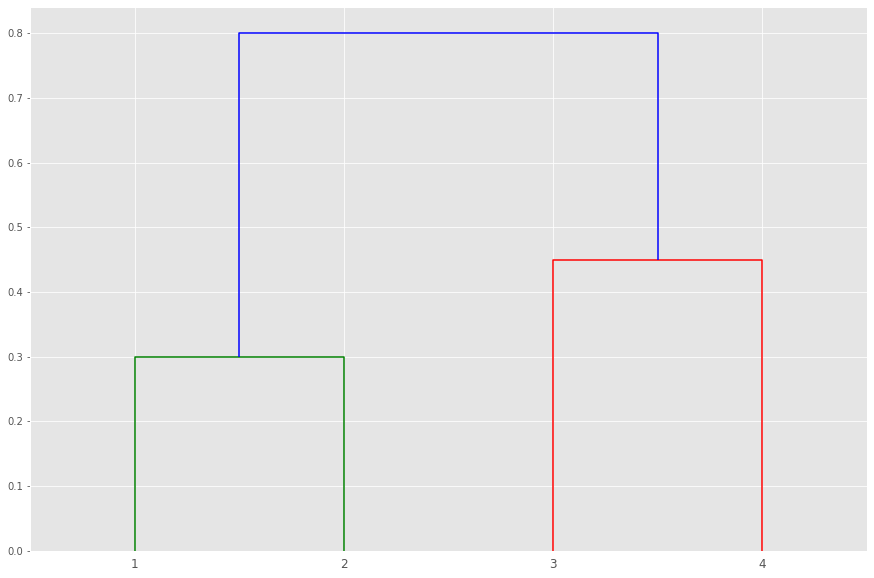

In [64]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

mat = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45], [0.7, 0.8, 0.45, 0.0]])


linkage_matrix = linkage(squareform(mat), "complete")



dendrogram(linkage_matrix, labels=["1", "2", "3", "4"])

plt.show()

### (b) Repeat (a), this time using single linkage clustering.


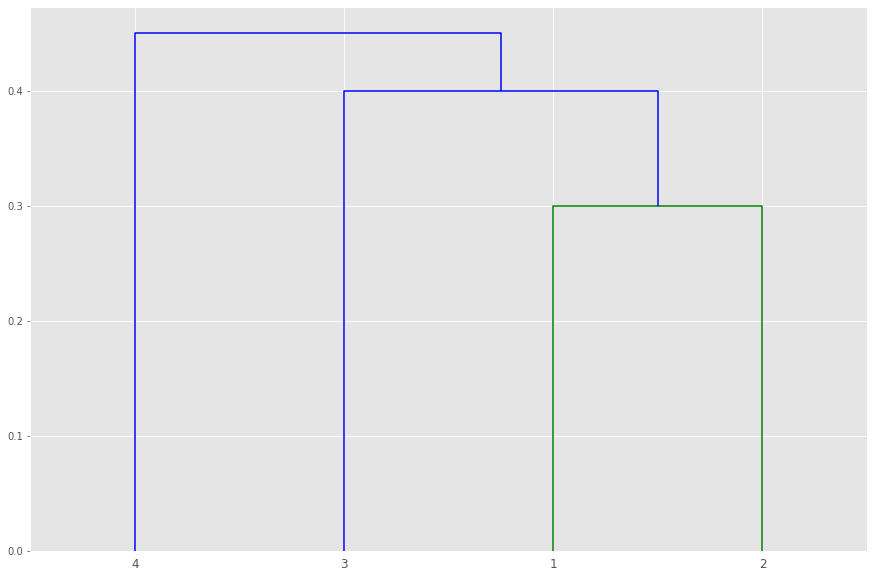

In [65]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

linkage_matrix = linkage(squareform(mat), "single")

dendrogram(linkage_matrix, labels=["1", "2", "3", "4"])
plt.show()

### (c)Suppose that we cut the dendrogram obtained in (a) such thattwo clusters result. Which observations are in each cluster?

Observations 1 and 2 are in Cluster A.
3 and 4 in Cluster B.

### (d) Suppose that we cut the dendogram obtained in (b) such that two clusters result. Which observations are in each cluster?

 Observations 1, 2 and 3 are in Cluster A
 4 in Cluster B.

### (e)It is mentioned in the chapter that at each fusion in the den-drogram, the position of the two clusters being fused can beswapped without changing the meaning of the dendrogram. Drawa dendrogram that is equivalent to the dendrogram in (a), forwhich two or more of the leaves are repositioned, but for whichthe meaning of the dendrogram is the same.

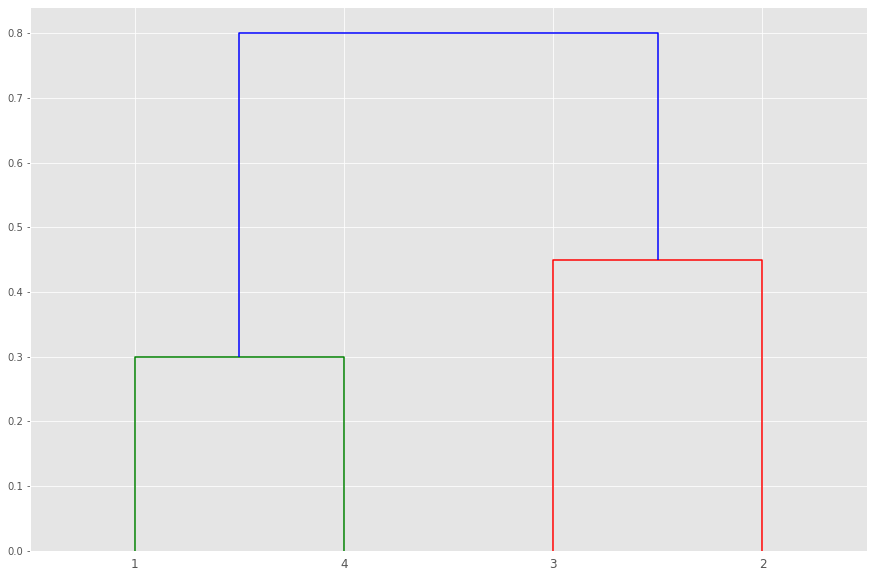

In [66]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

mat = np.array([[0.0, 0.3, 0.4, 0.7], [0.3, 0.0, 0.5, 0.8], [0.4, 0.5, 0.0, 0.45], [0.7, 0.8, 0.45, 0.0]])

linkage_matrix = linkage(squareform(mat), "complete")

dendrogram(linkage_matrix, labels=["1", "4", "3", "2"])

plt.show()